In [1]:
import os
import openai
import pandas as pd
import tiktoken
import numpy as np
from dotenv import load_dotenv
from openai import OpenAI
from langchain.schema import Document
from langchain_pinecone import PineconeVectorStore
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import Pinecone
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Necessary pip installation commands include:
- pip install os
- pip install openai
- pip install pandas
- pip install tiktoken
- pip install numpy
- pip install python-dotenv
- pip install langchain
- pip install langchain-pinecone
- pip install langchain-core
- pip install langchain-openai

#### <b>Note</b>: have a <b>.env</b> file already created for accessing API key

In [2]:
# retrieving API Key from OpenAI platform
load_dotenv()
# Initialize the tokenizer for GPT-3.5 Turbo and GPT-4
tokenizer = tiktoken.get_encoding("cl100k_base")
input_token_cost = ((2.50 / 1000000))
output_token_cost = ((10.00 / 1000000))
FINE_TUNED_TOXIC_DETECTION_API_KEY = os.getenv('FINE_TUNED_TOXIC_DETECTION_API_KEY')
pinecone_api_key = os.getenv('PINECONE_API_KEY')
pc_index = os.getenv('PINECONE_GPT')

In [3]:
# initializing Pinecone vector database instance
docSearch = Pinecone(
    index_name=pc_index,
    embedding=OpenAIEmbeddings()
)

C:\Users\elija\AppData\Local\Temp\ipykernel_22368\130847528.py:2: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.3 and will be removed in 0.3.0. Use :class:`~PineconeVectorStore` instead.
  docSearch = Pinecone(


In [4]:
# instantiating client with API key
fine_tuned = OpenAI(
    api_key=FINE_TUNED_TOXIC_DETECTION_API_KEY
)

In [5]:
# creating container for holding model completions for comparison
df = pd.read_csv('../../data/csv/semi_toxic_classification_evaluation_set.csv')
df['Toxic'] = df['Toxic'].apply(lambda x: str(int(x)))
df

,Text,Toxic
0,Date When did this algorithm get invented ?,0
1,answered them many times ! but they didnt answ...,0
2,IAC There is a discussion on article 's talk p...,0
3,Spandam 's laugh ? I 'm listening to it and al...,0
4,AND HAVING A FUCKIN ' BITCH ASS DAY '' ',1
...,...,...
995,"Oh , well Harry finally got his payback on me ...",1
996,this page is about random crap talk .. just ed...,1
997,I 've reverted the editsBOTH OF THEM VIOLATED ...,0
998,"I used the exact same bullshit you wrote , hyp...",1


In [6]:
# retrieving dataset utilized for evaluation
tuned = pd.DataFrame(columns=['Text', 'Toxic'])
tokens = pd.DataFrame(columns=['Prompt', 'Input', 'Output', 'Total'])

In [7]:
evaluation_prompt = ''
# Read the evaluation prompt from the text file with utf-8 encoding
with open("../../data/text/fine_tuned_prompts/gpt-4-two-shot-prompt.txt", "r", encoding="utf-8") as file:
    evaluation_prompt += file.read()

In [8]:
evaluation_prompt

'Classify these comments as either toxic (1) non-toxic (0). Toxic comments contain offensive, harmful, or abusive language. Label 1 for toxic and 0 for non-toxic\n\nExamples for Reference:\n\nText: “I disagree with your point, but I respect your view.”\n\nLabel: 0\n\nText: “Go back to where you came from.”\n\nLabel: 1\n\nClassify the following comment:'

In [9]:
# processing fine-tuned GPT-4o model across entire dataset with advanced prompt
for index, row in df.iterrows():
    text = row['Text']
    print(f"Starting Completion at Index: {index}")
    completion = fine_tuned.chat.completions.create(
        model="ft:gpt-4o-2024-08-06:personal::AuqN5AdH",
        messages=[
            {
                "role": "system", 
                "content": evaluation_prompt
            },
            {
                "role": "user",
                "content": text
            }
        ],
        max_tokens=10
    )
    print(f'Finished Completion {index}!')
    tuned.loc[index] = [row['Text'], completion.choices[0].message.content]
    # tokenize the string
    tokens_object = {
        'prompt': len(tokenizer.encode(evaluation_prompt)),
        'input': len(tokenizer.encode(row['Text'])),
        'output': len(tokenizer.encode(completion.choices[0].message.content))
    }
    total_tokens = tokens_object['prompt'] + tokens_object['input'] + tokens_object['output']
    tokens.loc[index] = [tokens_object['prompt'], tokens_object['input'], tokens_object['output'], total_tokens]


Starting Completion at Index: 0
Finished Completion 0!
Starting Completion at Index: 1
Finished Completion 1!
Starting Completion at Index: 2
Finished Completion 2!
Starting Completion at Index: 3
Finished Completion 3!
Starting Completion at Index: 4
Finished Completion 4!
Starting Completion at Index: 5
Finished Completion 5!
Starting Completion at Index: 6
Finished Completion 6!
Starting Completion at Index: 7
Finished Completion 7!
Starting Completion at Index: 8
Finished Completion 8!
Starting Completion at Index: 9
Finished Completion 9!
Starting Completion at Index: 10
Finished Completion 10!
Starting Completion at Index: 11
Finished Completion 11!
Starting Completion at Index: 12
Finished Completion 12!
Starting Completion at Index: 13
Finished Completion 13!
Starting Completion at Index: 14
Finished Completion 14!
Starting Completion at Index: 15
Finished Completion 15!
Starting Completion at Index: 16
Finished Completion 16!
Starting Completion at Index: 17
Finished Completio

In [10]:
tokens

,Prompt,Input,Output,Total
0,86,8,1,95
1,86,20,1,107
2,86,13,1,100
3,86,31,1,118
4,86,13,1,100
...,...,...,...,...
995,86,166,1,253
996,86,12,1,99
997,86,18,1,105
998,86,12,1,99


In [11]:
tuned

,Text,Toxic
0,Date When did this algorithm get invented ?,0
1,answered them many times ! but they didnt answ...,0
2,IAC There is a discussion on article 's talk p...,0
3,Spandam 's laugh ? I 'm listening to it and al...,0
4,AND HAVING A FUCKIN ' BITCH ASS DAY '' ',1
...,...,...
995,"Oh , well Harry finally got his payback on me ...",1
996,this page is about random crap talk .. just ed...,1
997,I 've reverted the editsBOTH OF THEM VIOLATED ...,0
998,"I used the exact same bullshit you wrote , hyp...",1


In [12]:
tuned = tuned[['Toxic']]
predictions = df[['Toxic']]

In [13]:
# comparing results of model to dataset
compare = tuned['Toxic'] == df['Toxic']
gptfour_finetuned_accuracy = compare.values.sum() / compare.size

In [14]:
compare

0      True
1      True
2      True
3      True
4      True
       ... 
995    True
996    True
997    True
998    True
999    True
Name: Toxic, Length: 1000, dtype: bool

In [15]:
# fine-tuned GPT-4o model accuracy with advanced prompted engineering (role prompting, two-shot examples) 95.20%
print(f"Accuracy: {gptfour_finetuned_accuracy * 100:.2f}%")

Accuracy: 95.20%


In [16]:
f1 = f1_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))


In [17]:
f1 # 0.9525691699604744

0.9525691699604744

In [18]:
# Precision: 0.964
# ROC AUC Score: 0.9522605020491803
precision = precision_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))
roc_auc_score = roc_auc_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))
cm = confusion_matrix(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))

In [19]:
print(f'Precision: {precision}')
print(f'ROC AUC Score: {roc_auc_score}')

Precision: 0.964
ROC AUC Score: 0.9522605020491803


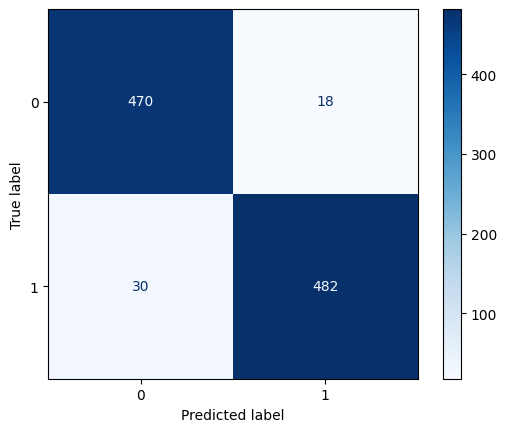

In [20]:
# Optional: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

In [21]:
# total token input cost: $0.3859175
((tokens['Input'].sum() + tokens['Prompt'].sum()) * input_token_cost)

0.3859175

In [22]:
# total token output cost: $0.01
(tokens['Output'].sum() * output_token_cost)

0.01

In [23]:
# complete total token cost: $0.39591750000000003
((tokens['Input'].sum() + tokens['Prompt'].sum()) * input_token_cost) + (tokens['Output'].sum() * output_token_cost)

0.39591750000000003

In [24]:
# 155367
tokens['Total'].sum()

155367